In [1]:

from astropy.table import Table, join
from astropy.cosmology import Planck18 as cosmo
from matplotlib import pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from scipy.optimize import minimize
from scipy.special import erfc

import numpy as np
import matplotlib.colors as colors
import sncosmo
import lcdata

import parsnip



In [3]:
model = parsnip.load_model('../parsnip-mod/models/model_roman_full.pt')
lcs = np.load('roman_test_predictions.npy', allow_pickle=True)


/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/parsnip/parsnip.py:299: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  self.band_interpolate_weights = torch.FloatTensor(band_weights).to(self.device)


In [4]:
roman_classifier = parsnip.Classifier()
dataset = lcdata.read_hdf5('roman_test.h5')
preds = model.predict_dataset(dataset, augment=True)

Preprocessing dataset: 100%|██████████| 5985/5985 [00:04<00:00, 1248.52it/s]
Length (128,) for reference_time
Length (128,) for reference_time_error
Length (128,) for color
Length (128,) for color_error
Length (128,) for amplitude
Length (128,) for amplitude_error
Length (128,) for s1
Length (128,) for s1_error
Length (128,) for s2
Length (128,) for s2_error
Length (128,) for s3
Length (128,) for s3_error
Length (128,) for total_s2n
Length (128,) for count
Length (128,) for count_s2n_3
Length (128,) for count_s2n_5
Length (128,) for count_s2n_3_pre
Length (128,) for count_s2n_3_rise
Length (128,) for count_s2n_3_fall
Length (128,) for count_s2n_3_post
Length (128,) for model_chisq
Length (128,) for model_dof
22
1
Length (128,) for reference_time
Length (128,) for reference_time_error
Length (128,) for color
Length (128,) for color_error
Length (128,) for amplitude
Length (128,) for amplitude_error
Length (128,) for s1
Length (128,) for s1_error
Length (128,) for s2
Length (128,) for s2

In [5]:
"""dropped_types = ['ILOT', 'PISNb', 'TDE', 'SLSN']
mask = ~np.isin(preds['type'],dropped_types)

# Apply the mask to the table
preds_fl = preds[mask]"""

roman_plot_labels = ["SNIa",
"91bg-like",
"SNIax",
"CCSN",
"SLSN",
"ILOT",
"TDE",
"PISNb"]
preds['original_object_id'] = preds['object_id']

In [6]:

roman_train = lcdata.read_hdf5('roman_train.h5')
pred_train = model.predict_dataset(roman_train)

Preprocessing dataset: 100%|██████████| 60000/60000 [00:58<00:00, 1027.62it/s]
Length (128,) for reference_time
Length (128,) for reference_time_error
Length (128,) for color
Length (128,) for color_error
Length (128,) for amplitude
Length (128,) for amplitude_error
Length (128,) for s1
Length (128,) for s1_error
Length (128,) for s2
Length (128,) for s2_error
Length (128,) for s3
Length (128,) for s3_error
Length (128,) for total_s2n
Length (128,) for count
Length (128,) for count_s2n_3
Length (128,) for count_s2n_5
Length (128,) for count_s2n_3_pre
Length (128,) for count_s2n_3_rise
Length (128,) for count_s2n_3_fall
Length (128,) for count_s2n_3_post
Length (128,) for model_chisq
Length (128,) for model_dof
22
1
Length (128,) for reference_time
Length (128,) for reference_time_error
Length (128,) for color
Length (128,) for color_error
Length (128,) for amplitude
Length (128,) for amplitude_error
Length (128,) for s1
Length (128,) for s1_error
Length (128,) for s2
Length (128,) for 

In [7]:
roman_classifier = parsnip.Classifier()
pred_train['original_object_id'] = pred_train['object_id']
classifications_train = roman_classifier.train(pred_train, num_folds=10)


Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    luminosity
    luminosity_error
    reference_time_error
Label distribution before folding: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 1100, 42195,    32,     9,    65, 15731,   832,    36]))


/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 0.601232


/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 0.651576


/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 0.534159


/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 0.803482


/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 0.629607


/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 0.80064


/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.06359


/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.07814


/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 0.557861


/home/belal/anaconda3/envs/shakinaz/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 0.569897


In [8]:
classifications = roman_classifier.classify(preds)

Macro averaged completeness (Villar et al. 2020): 0.7125
Fraction correct: 0.7003


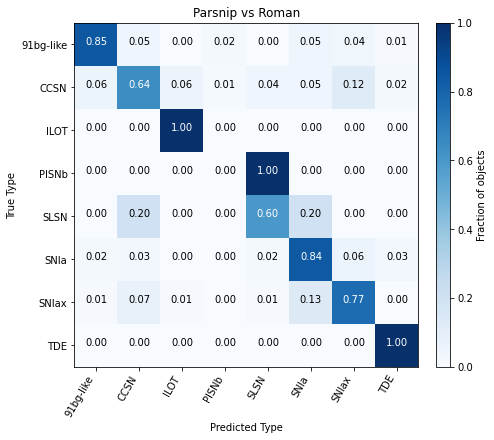

In [11]:

parsnip.plot_confusion_matrix(preds, classifications, title = 'Parsnip vs Roman', figsize=(8,6))
plt.savefig('confustion_matrix_ps_roman.pdf')

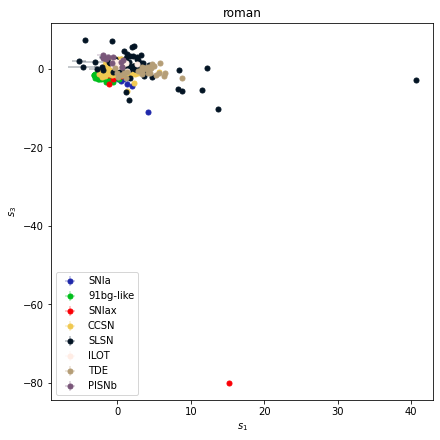

In [15]:
parsnip.plot_representation(pred_train, roman_plot_labels, idx1=1, idx2=3, max_count=200)
plt.title('roman')

plt.savefig('./roman_classification13.pdf')

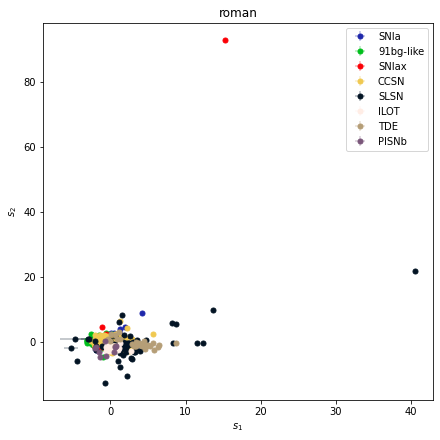

In [14]:
parsnip.plot_representation(pred_train, roman_plot_labels, idx1=1, idx2=2, max_count=200)
plt.title('roman')

plt.savefig('./roman_classification12.pdf')

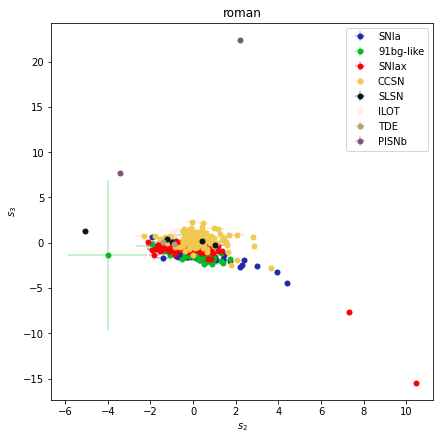

In [12]:
parsnip.plot_representation(preds, roman_plot_labels, idx1=2, idx2=3, max_count=100)
plt.title('roman')

plt.savefig('./roman_classification23.pdf')

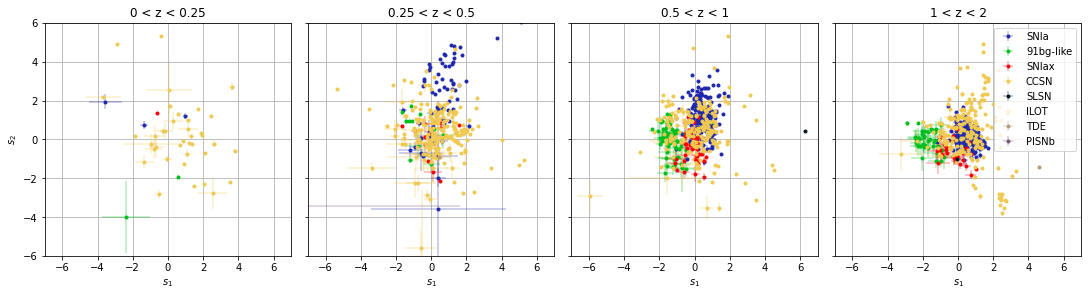

In [13]:
bins = (
    (0, 0.25),
    (0.25, 0.5),
    (0.5, 1),
    (1, 2),
)

fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True,
                         gridspec_kw={'wspace': 0.05, 'hspace': 0.02}, constrained_layout=True)

for idx in range(len(bins)):
    ax = axes[idx]
    min_z, max_z = bins[idx]
    predictions=preds

    mask = (predictions['redshift'] > min_z) & (predictions['redshift'] < max_z)
    use_pred = predictions[mask]
    use_pred.sort('total_s2n', reverse=True)

    kwargs = {}

    if idx == 3:
        kwargs['legend_ncol'] = 1
    else:
        kwargs['show_legend'] = False

    # Common plot
    parsnip.plot_representation(use_pred, roman_plot_labels, idx1=1, idx2=2, max_count=200,
                                markersize=3, ax=ax, **kwargs)
    ax.set_title(f'{min_z} < z < {max_z}')
    ax.set_xlim(-7., 7.)
    ax.set_ylim(-6, 6)
    if idx > 0:
        ax.set_ylabel('')
    ax.grid()
fig.savefig('roman_z_representation12.pdf')

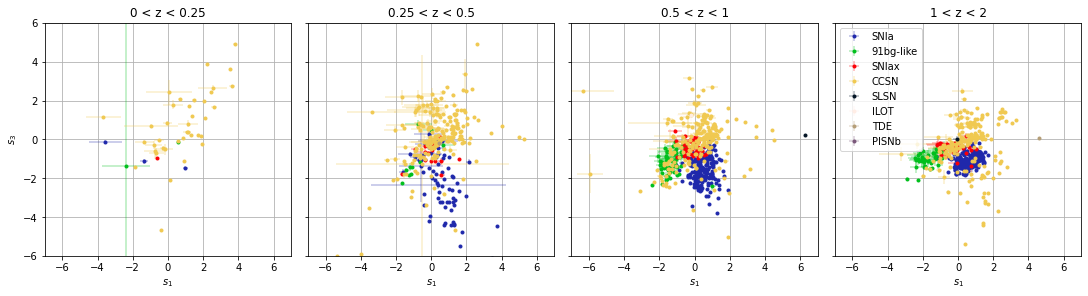

In [14]:
bins = (
    (0, 0.25),
    (0.25, 0.5),
    (0.5, 1),
    (1, 2),
)

fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True,
                         gridspec_kw={'wspace': 0.05, 'hspace': 0.02}, constrained_layout=True)

for idx in range(len(bins)):
    ax = axes[idx]
    min_z, max_z = bins[idx]

    mask = (predictions['redshift'] > min_z) & (predictions['redshift'] < max_z)
    use_pred = predictions[mask]
    use_pred.sort('total_s2n', reverse=True)

    kwargs = {}

    if idx == 3:
        kwargs['legend_ncol'] = 1
    else:
        kwargs['show_legend'] = False

    # Common plot
    parsnip.plot_representation(use_pred, roman_plot_labels, idx1=1, idx2=3, max_count=200,
                                markersize=3, ax=ax, **kwargs)
    ax.set_title(f'{min_z} < z < {max_z}')
    ax.set_xlim(-7., 7.)
    ax.set_ylim(-6, 6)
    if idx > 0:
        ax.set_ylabel('')
    ax.grid()
fig.savefig('roman_z_representation13.pdf')

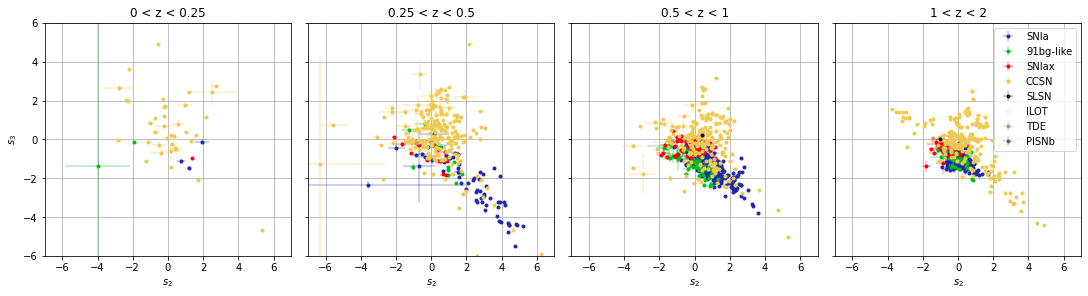

In [15]:
bins = (
    (0, 0.25),
    (0.25, 0.5),
    (0.5, 1),
    (1, 2),
)

fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True,
                         gridspec_kw={'wspace': 0.05, 'hspace': 0.02}, constrained_layout=True)

for idx in range(len(bins)):
    ax = axes[idx]
    min_z, max_z = bins[idx]

    mask = (predictions['redshift'] > min_z) & (predictions['redshift'] < max_z)
    use_pred = predictions[mask]
    use_pred.sort('total_s2n', reverse=True)

    kwargs = {}

    if idx == 3:
        kwargs['legend_ncol'] = 1
    else:
        kwargs['show_legend'] = False

    # Common plot
    parsnip.plot_representation(use_pred, roman_plot_labels, idx1=2, idx2=3, max_count=200,
                                markersize=3, ax=ax, **kwargs)
    ax.set_title(f'{min_z} < z < {max_z}')
    ax.set_xlim(-7., 7.)
    ax.set_ylim(-6, 6)
    if idx > 0:
        ax.set_ylabel('')
    ax.grid()
fig.savefig('roman_z_representation23.pdf')